In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r"DWLR_dataset.csv", encoding='ISO-8859-1', parse_dates=["Date & Time"])

In [4]:
# 2. Data Cleaning: Drop missing critical values
df = df.dropna(subset=["Water Level (m)", "Latitude", "Longitude", "Village", "District", "State"])

In [5]:
# 3. Feature Engineering: Extract month
df["Month"] = df["Date & Time"].dt.month

In [6]:
# 4. Aggregate monthly mean water level per location (Village-level)
monthly = df.groupby(["State", "District", "Village", "Latitude", "Longitude", "Month"])["Water Level (m)"].mean().reset_index()

In [7]:
# 5. Create Low/Moderate/High labels per Village based on quantiles
def classify_level(row, thresholds):
    if row["Water Level (m)"] < thresholds[0]:
        return "Low"
    elif row["Water Level (m)"] < thresholds[1]:
        return "Moderate"
    else:
        return "High"

monthly["Level"] = None
for village, group in monthly.groupby("Village"):
    q1 = group["Water Level (m)"].quantile(0.33)
    q2 = group["Water Level (m)"].quantile(0.66)
    idx = group.index
    monthly.loc[idx, "Level"] = group.apply(lambda x: classify_level(x, [q1, q2]), axis=1)

In [8]:
# 6. Encode target labels
le = LabelEncoder()
monthly["Level_Code"] = le.fit_transform(monthly["Level"])

In [9]:
# 7. Prepare features and target
features = ["Latitude", "Longitude", "Month"]
X = monthly[features]
y = monthly["Level_Code"]

In [10]:
# 8. Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# 9. Train RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# 10. Predict on test set
y_pred = model.predict(X_test)

In [13]:
# 11. Evaluate model
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.7620

Classification Report:
              precision    recall  f1-score   support

        High       0.81      0.82      0.81       224
         Low       0.77      0.79      0.78       222
    Moderate       0.71      0.67      0.69       218

    accuracy                           0.76       664
   macro avg       0.76      0.76      0.76       664
weighted avg       0.76      0.76      0.76       664



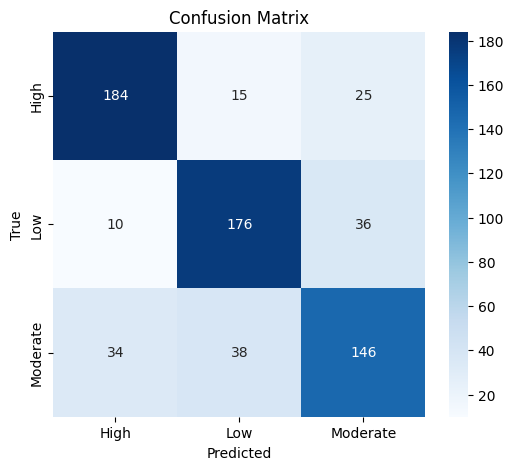

In [14]:
# 12. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# 13. Save model and label encoder
joblib.dump(model, "groundwater_level_model.pkl")
joblib.dump(le, "label_encoder.pkl")

print("Model and label encoder saved successfully.")

Model and label encoder saved successfully.
